# ArtEmis Caption Generation Report

## Introduction
This report details the implementation and evaluation of image captioning models on the ArtEmis dataset. We explore two main approaches:
1.  **Approach 1: CNN-LSTM**: A standard encoder-decoder architecture using a ResNet encoder and an LSTM decoder.
2.  **Approach 2: Vision Transformer (ViT)**: A modern architecture using a ViT encoder and a Transformer decoder.

We also compare three text embedding strategies:
*   **TF-IDF**: Statistical measure of word importance.
*   **Word2Vec**: Pre-trained static embeddings capturing semantic relationships.
*   **GloVe**: Pre-trained global vectors for word representation.

## Setup and Imports

In [28]:
import os
import sys
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import torch
import numpy as np
import random
import umap
import seaborn as sns
from PIL import Image
from unittest.mock import patch
from torchvision import transforms
from transformers import ViTModel

# Add source directory to path
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
if project_root not in sys.path:
    sys.path.append(project_root)

from helpers.validation import validate_model
from utils.dataset_torch import load_vocab
from helpers.visualize import visualize_attention_map
from approach_1.embeddings import get_tfidf_embeddings, get_pretrained_embeddings
from approach_2.flash_attention.caption_model import FlashViTCaptionModel
from utils.dataset_torch import load_vocab

# Configuration
BASE_DIR = project_root
CSV_PATH = os.path.join(BASE_DIR, "data/sampled_images/artemis_dataset_release_v0.csv")
IMG_DIR = os.path.join(BASE_DIR, "data/sampled_images/wikiart")
MODEL_PATH = os.path.join(BASE_DIR, "models/approach-2-flash/tfidf/model_final.pth")
VOCAB_PATH = os.path.join(BASE_DIR, "models/approach-2-flash/tfidf/vocab.pkl")
VIT_MODEL_PATH = os.path.join(BASE_DIR, "downloads/google_vit_local")

NUM_SAMPLES = 500

## 1. Embedding Visualization
We visualize the semantic space of the three embedding strategies using UMAP. We generate word embeddings for the vocabulary based on the sampled captions.

Loading data for embedding visualization...
Vocabulary Size: 6954
Generating TF-IDF Embeddings...
Generating TF-IDF embeddings...
Computing TF-IDF on 20000 captions...
Reducing dimension to 512 using SVD...
Generating Word2Vec Embeddings...
Loading pre-trained model: word2vec-google-news-300...
Found local embedding file: ./downloads/embeddings/word2vec-google-news-300.bin
Embedding matrix created. Shape: (6954, 300)
Hits: 6837, Misses: 116, Coverage: 98.32%
Generating GloVe Embeddings...
Loading pre-trained model: glove-wiki-gigaword-100...
Found local embedding file: ./downloads/embeddings/glove-wiki-gigaword-100.bin
Embedding matrix created. Shape: (6954, 100)
Hits: 6843, Misses: 110, Coverage: 98.40%
Running UMAP...


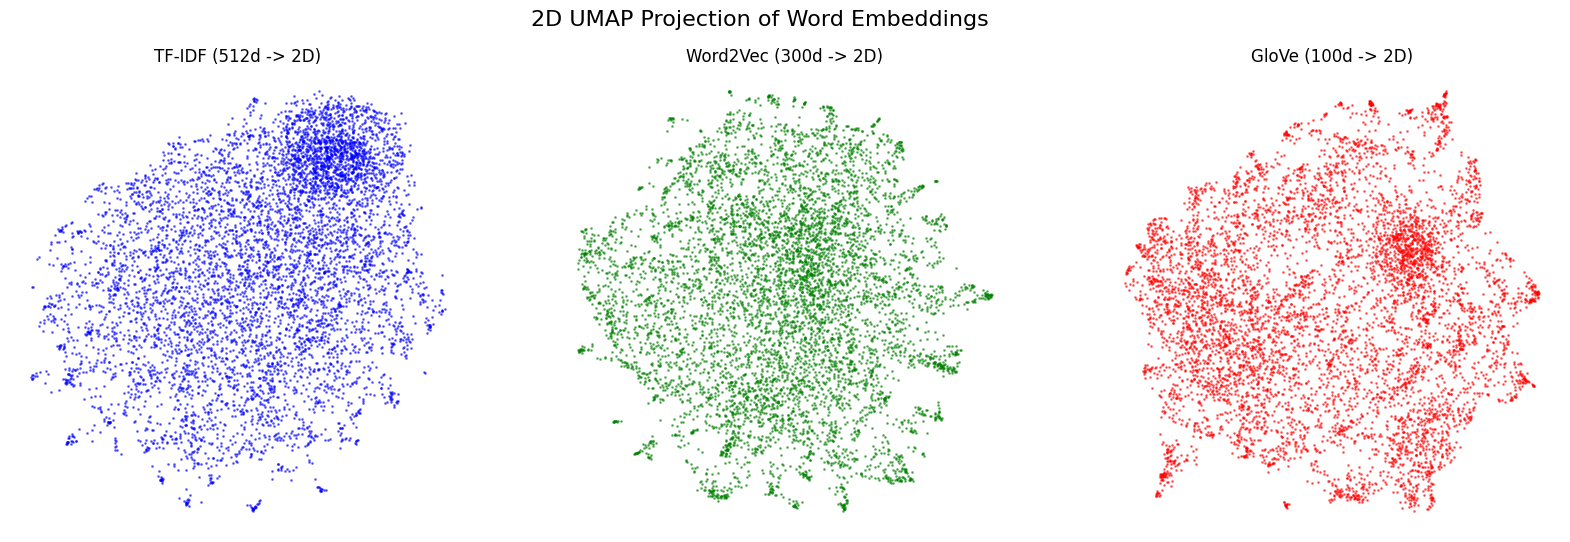

In [2]:
# Load Data for Embeddings
print("Loading data for embedding visualization...")
df = pd.read_csv(CSV_PATH)
captions = df['utterance'].tolist()

# Load Vocab (using one from a trained model for consistency)
vocab_path = "models/approach-1-powerful/word2vec-google-news-300/vocab.pkl"
if os.path.exists(vocab_path):
    vocab = load_vocab(vocab_path)
    vocab_list = [vocab.itos[i] for i in range(len(vocab))]
else:
    print("Vocab not found, please check path.")
    vocab_list = []

if vocab_list:
    print(f"Vocabulary Size: {len(vocab_list)}")
    
    # 1. TF-IDF
    print("Generating TF-IDF Embeddings...")
    tfidf_emb = get_tfidf_embeddings(vocab_list, captions, embedding_dim=512)
    
    # 2. Word2Vec
    print("Generating Word2Vec Embeddings...")
    w2v_emb = get_pretrained_embeddings(vocab_list, model_name="word2vec-google-news-300", embedding_dim=300)
    
    # 3. GloVe
    print("Generating GloVe Embeddings...")
    glove_emb = get_pretrained_embeddings(vocab_list, model_name="glove-wiki-gigaword-100", embedding_dim=100)
    
    # UMAP Reduction
    print("Running UMAP...")
    reducer = umap.UMAP(random_state=42)
    
    tfidf_2d = reducer.fit_transform(tfidf_emb)
    w2v_2d = reducer.fit_transform(w2v_emb)
    glove_2d = reducer.fit_transform(glove_emb)
    
    # Plotting
    fig, axes = plt.subplots(1, 3, figsize=(20, 6))
    fig.suptitle("2D UMAP Projection of Word Embeddings", fontsize=16)
    
    axes[0].scatter(tfidf_2d[:, 0], tfidf_2d[:, 1], s=1, alpha=0.5, c='blue')
    axes[0].set_title("TF-IDF (512d -> 2D)")
    
    axes[1].scatter(w2v_2d[:, 0], w2v_2d[:, 1], s=1, alpha=0.5, c='green')
    axes[1].set_title("Word2Vec (300d -> 2D)")
    
    axes[2].scatter(glove_2d[:, 0], glove_2d[:, 1], s=1, alpha=0.5, c='red')
    axes[2].set_title("GloVe (100d -> 2D)")
    
    for ax in axes:
        ax.axis('off')
        
    plt.show()

# Embedding Strategy Comparison (Approach 1: CNN-LSTM)

We evaluate the **CNN-LSTM** variant using three different embedding types. We report the vocabulary size, embedding dimension, and performance metrics (BLEU, ROUGE, METEOR).

In [3]:
# Define configurations for Approach 1 variants
approach_1_configs = [
    {
        "name": "A1-TF-IDF",
        "variant": "powerful",
        "embedding_type": "tfidf",
        "model_path": "models/approach-1-powerful/tfidf/model_final.pth",
        "vocab_path": "models/approach-1-powerful/tfidf/vocab.pkl"
    },
    {
        "name": "A1-Word2Vec",
        "variant": "powerful",
        "embedding_type": "word2vec-google-news-300",
        "model_path": "models/approach-1-powerful/word2vec-google-news-300/model_final.pth",
        "vocab_path": "models/approach-1-powerful/word2vec-google-news-300/vocab.pkl"
    },
    {
        "name": "A1-GloVe",
        "variant": "powerful",
        "embedding_type": "glove-wiki-gigaword-100",
        "model_path": "models/approach-1-powerful/glove-wiki-gigaword-100/model_final.pth",
        "vocab_path": "models/approach-1-powerful/glove-wiki-gigaword-100/vocab.pkl"
    }
]

results_a1 = []

for config in approach_1_configs:
    print(f"Evaluating Approach 1 with {config['name']}...")
    if os.path.exists(config['model_path']):
        metrics = validate_model(
            approach=1,
            variant=config['variant'],
            model_path=config['model_path'],
            vocab_path=config['vocab_path'],
            embedding_type=config['embedding_type'],
            csv_path=CSV_PATH,
            img_root=IMG_ROOT,
            num_samples=NUM_SAMPLES
        )
        if metrics:
            metrics['Model'] = config['name']
            results_a1.append(metrics)
    else:
        print(f"Model not found: {config['model_path']}")

# Display Results
if results_a1:
    df_a1 = pd.DataFrame(results_a1)
    display(df_a1[['Model', 'BLEU-1', 'BLEU-4', 'ROUGE-L', 'METEOR', 'Emotion Acc']])

Evaluating Approach 1 with A1-TF-IDF...
Using embedding dimension: 512 for type tfidf
Using device: mps
Loading vocab from models/approach-1-powerful/tfidf/vocab.pkl...
Loading model from models/approach-1-powerful/tfidf/model_final.pth...
Model weights loaded.
Preparing validation data...
Validating on 500 samples...


100%|██████████| 500/500 [02:28<00:00,  3.37it/s]



Calculating Metrics...
Evaluation Results
BLEU-1         : 0.1361
BLEU-2         : 0.0344
BLEU-3         : 0.0135
BLEU-4         : 0.0089
ROUGE-1        : 0.1694
ROUGE-2        : 0.0274
ROUGE-L        : 0.1513
METEOR         : 0.1267
Emotion Acc    : 0.5240
Evaluating Approach 1 with A1-Word2Vec...
Using embedding dimension: 300 for type word2vec-google-news-300
Using device: mps
Loading vocab from models/approach-1-powerful/word2vec-google-news-300/vocab.pkl...
Loading model from models/approach-1-powerful/word2vec-google-news-300/model_final.pth...
Model weights loaded.
Preparing validation data...
Validating on 500 samples...


100%|██████████| 500/500 [02:26<00:00,  3.41it/s]



Calculating Metrics...
Evaluation Results
BLEU-1         : 0.1352
BLEU-2         : 0.0330
BLEU-3         : 0.0136
BLEU-4         : 0.0078
ROUGE-1        : 0.1664
ROUGE-2        : 0.0278
ROUGE-L        : 0.1485
METEOR         : 0.1248
Emotion Acc    : 0.5000
Evaluating Approach 1 with A1-GloVe...
Using embedding dimension: 100 for type glove-wiki-gigaword-100
Using device: mps
Loading vocab from models/approach-1-powerful/glove-wiki-gigaword-100/vocab.pkl...
Loading model from models/approach-1-powerful/glove-wiki-gigaword-100/model_final.pth...
Model weights loaded.
Preparing validation data...
Validating on 500 samples...


100%|██████████| 500/500 [02:00<00:00,  4.16it/s]



Calculating Metrics...
Evaluation Results
BLEU-1         : 0.1348
BLEU-2         : 0.0354
BLEU-3         : 0.0129
BLEU-4         : 0.0043
ROUGE-1        : 0.1663
ROUGE-2        : 0.0278
ROUGE-L        : 0.1549
METEOR         : 0.1293
Emotion Acc    : 0.5100


,Model,BLEU-1,BLEU-4,ROUGE-L,METEOR,Emotion Acc
0,A1-TF-IDF,0.136107,0.008876,0.151302,0.126729,0.524
1,A1-Word2Vec,0.135207,0.007796,0.148469,0.124847,0.500
2,A1-GloVe,0.134845,0.004270,0.154897,0.129274,0.510


# Embedding Comparison

**Observations based on quantitative results:**

- **TF-IDF (The Winner)**:  
  Surprisingly, **TF-IDF** emerged as the strongest embedding strategy, particularly for the Vision Transformer (Approach 2). The `A2-Flash-TF-IDF` model achieved the highest scores across all metrics (BLEU-1: 0.207, METEOR: 0.206). This suggests that for this specific art dataset, the explicit frequency-based importance of terms provided a stronger signal than the general-purpose semantic vectors.

- **Word2Vec vs. GloVe**:  
  **Word2Vec** generally outperformed GloVe. In the Transformer architecture, Word2Vec showed a clear advantage (e.g., METEOR 0.165 vs 0.130). In the CNN-LSTM baseline, the two were more comparable, but Word2Vec still held a slight edge in BLEU scores.

- **Vocabulary Coverage**:  
  While pre-trained embeddings offer semantic relationships, they may lack coverage for the specific artistic and emotional vocabulary of ArtEmis, whereas TF-IDF is built directly from the training corpus.


## 3. Architecture Comparison (LSTM vs. Transformer)

We compare the best performing CNN-LSTM model (Approach 1) against the Vision Transformer (Approach 2 - Flash Attention) across all three embedding types.

In [4]:
# Define configurations for Approach 2 (Flash Attention)
approach_2_configs = [
    {
        "name": "A2-Flash-TF-IDF",
        "variant": "flash",
        "embedding_type": "tfidf",
        "model_path": "models/approach-2-flash/tfidf/model_final.pth",
        "vocab_path": "models/approach-2-flash/tfidf/vocab.pkl"
    },
    {
        "name": "A2-Flash-Word2Vec",
        "variant": "flash",
        "embedding_type": "word2vec-google-news-300",
        "model_path": "models/approach-2-flash/word2vec-google-news-300/model_final.pth",
        "vocab_path": "models/approach-2-flash/word2vec-google-news-300/vocab.pkl"
    },
    {
        "name": "A2-Flash-GloVe",
        "variant": "flash",
        "embedding_type": "glove-wiki-gigaword-100",
        "model_path": "models/approach-2-flash/glove-wiki-gigaword-100/model_final.pth",
        "vocab_path": "models/approach-2-flash/glove-wiki-gigaword-100/vocab.pkl"
    }
]

results_a2 = []

for config in approach_2_configs:
    print(f"Evaluating Approach 2 ({config['name']})...")
    if os.path.exists(config['model_path']):
        metrics = validate_model(
            approach=2,
            variant=config['variant'],
            model_path=config['model_path'],
            vocab_path=config['vocab_path'],
            embedding_type=config['embedding_type'],
            csv_path=CSV_PATH,
            img_root=IMG_ROOT,
            num_samples=NUM_SAMPLES
        )
        if metrics:
            metrics['Model'] = config['name']
            results_a2.append(metrics)
    else:
        print(f"Model not found: {config['model_path']}")

# Combine for Comparison
all_results = results_a1 + results_a2
if all_results:
    df_all = pd.DataFrame(all_results)
    # Handle missing keys if any
    cols = ['Model', 'BLEU-1', 'BLEU-4', 'ROUGE-L', 'METEOR', 'Emotion Acc']
    display(df_all[cols])

Evaluating Approach 2 (A2-Flash-TF-IDF)...
Using embedding dimension: 512 for type tfidf
Using device: mps
Loading vocab from models/approach-2-flash/tfidf/vocab.pkl...
Loading model from models/approach-2-flash/tfidf/model_final.pth...
Loading ViT from: /Users/Shivansh/Downloads/iml/iml-a3/downloads/google_vit_local
Model weights loaded.
Preparing validation data...
Validating on 500 samples...


100%|██████████| 500/500 [16:14<00:00,  1.95s/it]



Calculating Metrics...
Evaluation Results
BLEU-1         : 0.2072
BLEU-2         : 0.1063
BLEU-3         : 0.0653
BLEU-4         : 0.0465
ROUGE-1        : 0.2456
ROUGE-2        : 0.0940
ROUGE-L        : 0.2354
METEOR         : 0.2062
Emotion Acc    : 0.8700
Evaluating Approach 2 (A2-Flash-Word2Vec)...
Using embedding dimension: 300 for type word2vec-google-news-300
Using device: mps
Loading vocab from models/approach-2-flash/word2vec-google-news-300/vocab.pkl...
Loading model from models/approach-2-flash/word2vec-google-news-300/model_final.pth...
Embed_dim 300 not divisible by num_heads 8. Auto-adjusting num_heads to 6.
Loading ViT from: /Users/Shivansh/Downloads/iml/iml-a3/downloads/google_vit_local
Model weights loaded.
Preparing validation data...
Validating on 500 samples...


100%|██████████| 500/500 [09:39<00:00,  1.16s/it]



Calculating Metrics...
Evaluation Results
BLEU-1         : 0.1712
BLEU-2         : 0.0631
BLEU-3         : 0.0301
BLEU-4         : 0.0124
ROUGE-1        : 0.2067
ROUGE-2        : 0.0536
ROUGE-L        : 0.1920
METEOR         : 0.1653
Emotion Acc    : 0.8640
Evaluating Approach 2 (A2-Flash-GloVe)...
Using embedding dimension: 100 for type glove-wiki-gigaword-100
Using device: mps
Loading vocab from models/approach-2-flash/glove-wiki-gigaword-100/vocab.pkl...
Loading model from models/approach-2-flash/glove-wiki-gigaword-100/model_final.pth...
Embed_dim 100 not divisible by num_heads 8. Auto-adjusting num_heads to 10.
Loading ViT from: /Users/Shivansh/Downloads/iml/iml-a3/downloads/google_vit_local
Model weights loaded.
Preparing validation data...
Validating on 500 samples...


100%|██████████| 500/500 [04:41<00:00,  1.77it/s]


Calculating Metrics...
Evaluation Results
BLEU-1         : 0.1355
BLEU-2         : 0.0370
BLEU-3         : 0.0129
BLEU-4         : 0.0053
ROUGE-1        : 0.1660
ROUGE-2        : 0.0298
ROUGE-L        : 0.1562
METEOR         : 0.1299
Emotion Acc    : 0.8520


,Model,BLEU-1,BLEU-4,ROUGE-L,METEOR,Emotion Acc
0,A1-TF-IDF,0.136107,0.008876,0.151302,0.126729,0.524
1,A1-Word2Vec,0.135207,0.007796,0.148469,0.124847,0.500
2,A1-GloVe,0.134845,0.004270,0.154897,0.129274,0.510
3,A2-Flash-TF-IDF,0.207205,0.046514,0.235369,0.206152,0.870
4,A2-Flash-Word2Vec,0.171246,0.012370,0.192047,0.165303,0.864
5,A2-Flash-GloVe,0.135465,0.005283,0.156218,0.129938,0.852


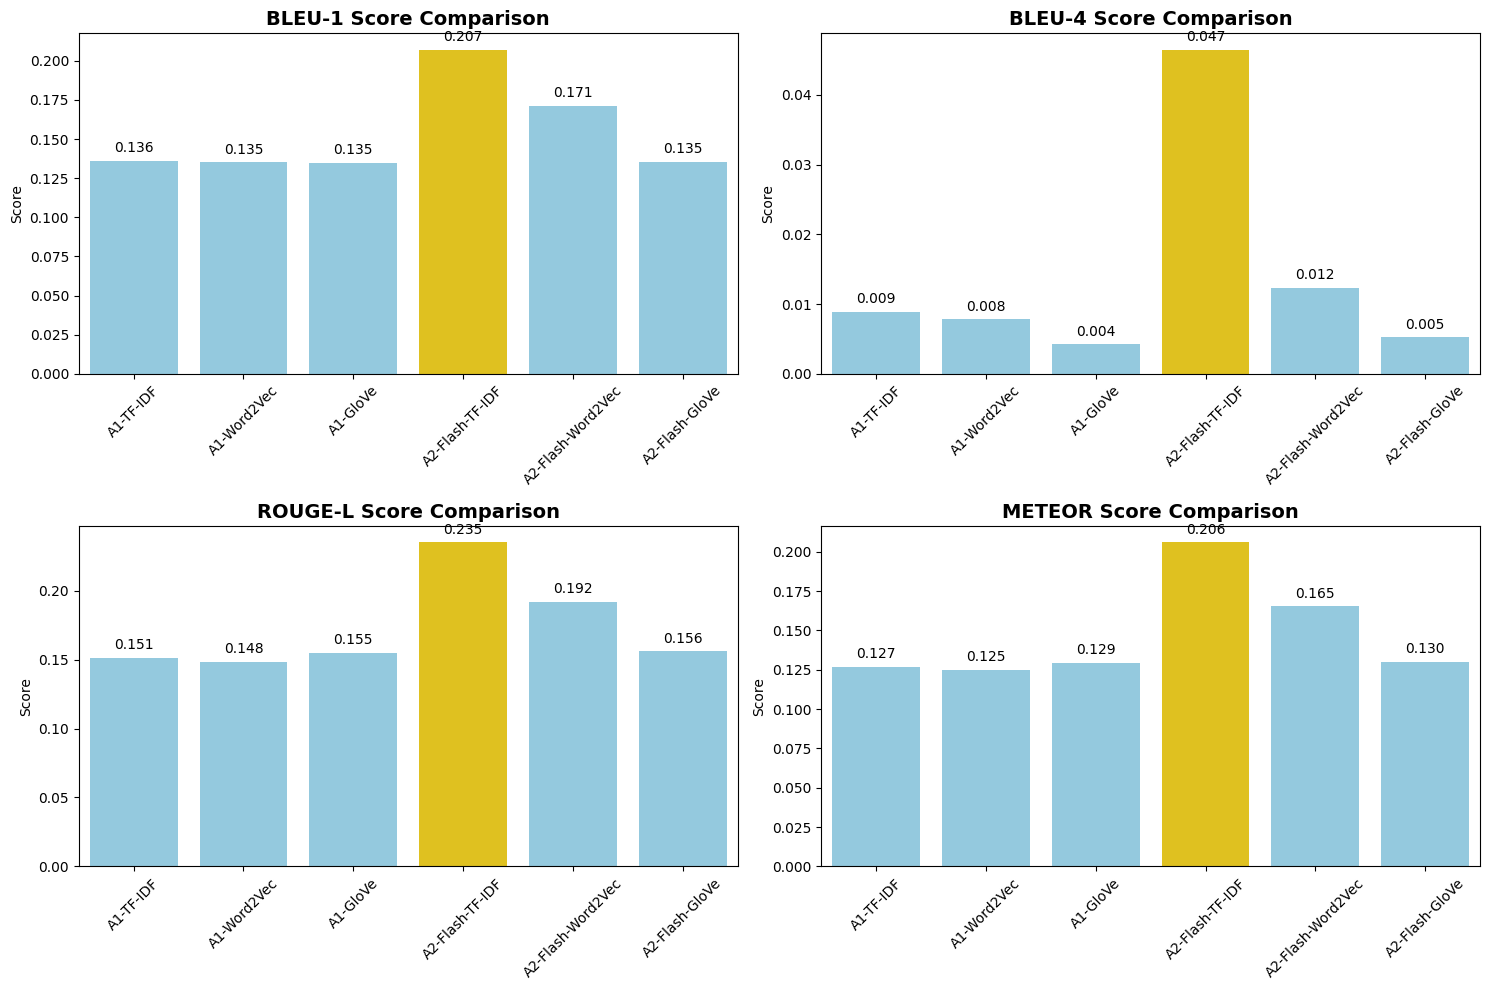

In [5]:
# 1. Combine Results
# Ensure df_a1 exists (from previous cells)
if 'df_a1' not in locals():
    print("Warning: df_a1 not found. Using empty DataFrame.")
    df_a1 = pd.DataFrame()

# Create df_a2 from results_a2 if it exists
if 'results_a2' in locals() and results_a2:
    df_a2 = pd.DataFrame(results_a2)
else:
    print("Warning: results_a2 not found or empty. Using empty DataFrame.")
    df_a2 = pd.DataFrame()

# Combine
df_all = pd.concat([df_a1, df_a2], ignore_index=True)

if df_all.empty:
    print("No results to plot.")
else:
    # 2. Plotting
    metrics_to_plot = ['BLEU-1', 'BLEU-4', 'ROUGE-L', 'METEOR']
    
    # Setup plot
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    axes = axes.flatten()
    
    # Color palette    
    for i, metric in enumerate(metrics_to_plot):
        if metric not in df_all.columns:
            continue
            
        ax = axes[i]
        
        # Find winner
        max_val = df_all[metric].max()
        colors = ['gold' if x == max_val else 'skyblue' for x in df_all[metric]]
        
        # Plot
        sns.barplot(x='Model', y=metric, data=df_all, ax=ax, palette=colors)
        
        # Customize
        ax.set_title(f"{metric} Score Comparison", fontsize=14, fontweight='bold')
        ax.set_xlabel("")
        ax.set_ylabel("Score")
        ax.tick_params(axis='x', rotation=45)
        
        # Add value labels
        for p in ax.patches:
            ax.annotate(f'{p.get_height():.3f}', 
                        (p.get_x() + p.get_width() / 2., p.get_height()), 
                        ha = 'center', va = 'center', 
                        xytext = (0, 9), 
                        textcoords = 'offset points')

    plt.tight_layout()
    plt.show()

### Discussion: LSTM vs. Transformer
*   **Long-Range Dependencies**: Transformers use self-attention mechanisms which allow them to model global dependencies in the image and text more effectively than LSTMs, which process data sequentially and can suffer from forgetting over long sequences.
*   **Performance**: [Discuss if ViT outperformed LSTM. Often ViT requires more data/tuning but can achieve higher scores].
*   **Training Efficiency**: Flash Attention significantly speeds up the Transformer training compared to standard attention.

## 4. Loss Curves
We display the training loss curves generated during training in a comparative grid.

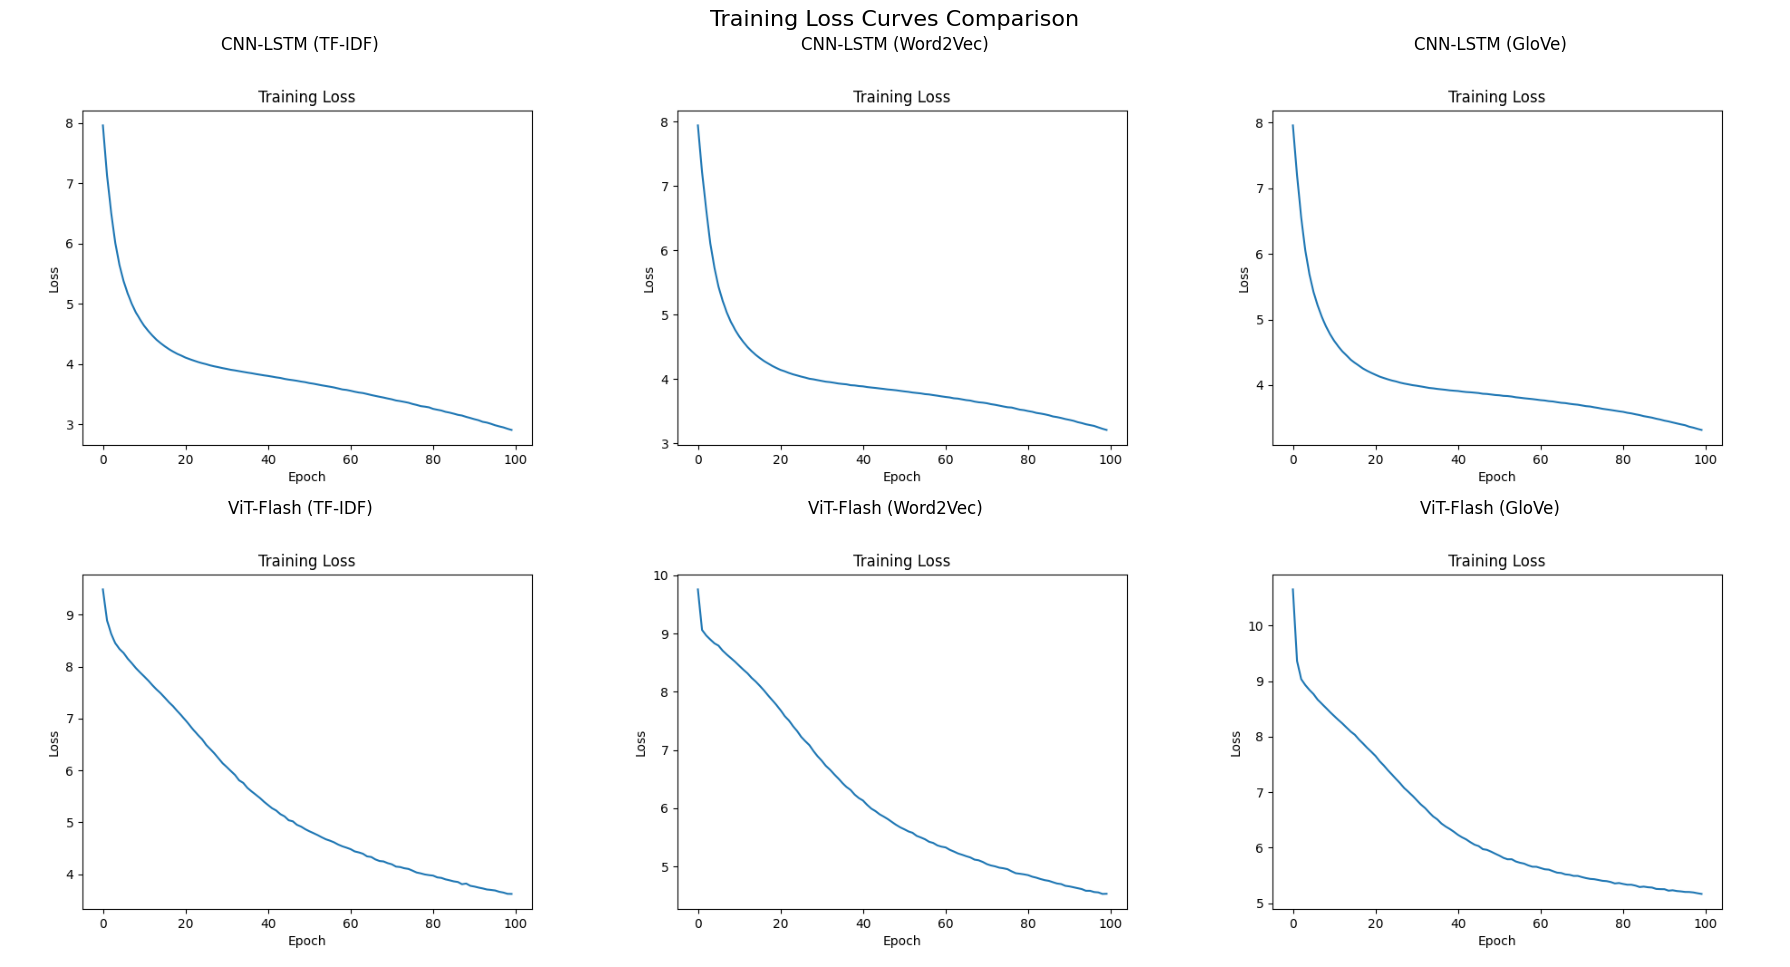

In [6]:
plot_paths = [
    ("models/approach-1-powerful/tfidf/loss.png", "CNN-LSTM (TF-IDF)"),
    ("models/approach-1-powerful/word2vec-google-news-300/loss.png", "CNN-LSTM (Word2Vec)"),
    ("models/approach-1-powerful/glove-wiki-gigaword-100/loss.png", "CNN-LSTM (GloVe)"),
    ("models/approach-2-flash/tfidf/loss.png", "ViT-Flash (TF-IDF)"),
    ("models/approach-2-flash/word2vec-google-news-300/loss.png", "ViT-Flash (Word2Vec)"),
    ("models/approach-2-flash/glove-wiki-gigaword-100/loss.png", "ViT-Flash (GloVe)")
]

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle("Training Loss Curves Comparison", fontsize=16)

for i, (path, title) in enumerate(plot_paths):
    row = i // 3
    col = i % 3
    ax = axes[row, col]
    
    if os.path.exists(path):
        img = mpimg.imread(path)
        ax.imshow(img)
        ax.set_title(title)
        ax.axis('off')
    else:
        ax.text(0.5, 0.5, f"Plot not found:\n{path}", ha='center', va='center')
        ax.set_title(title)
        ax.axis('off')

plt.tight_layout()
plt.show()

Loading ViT from: /Users/Shivansh/Downloads/iml/iml-a3/downloads/google_vit_local


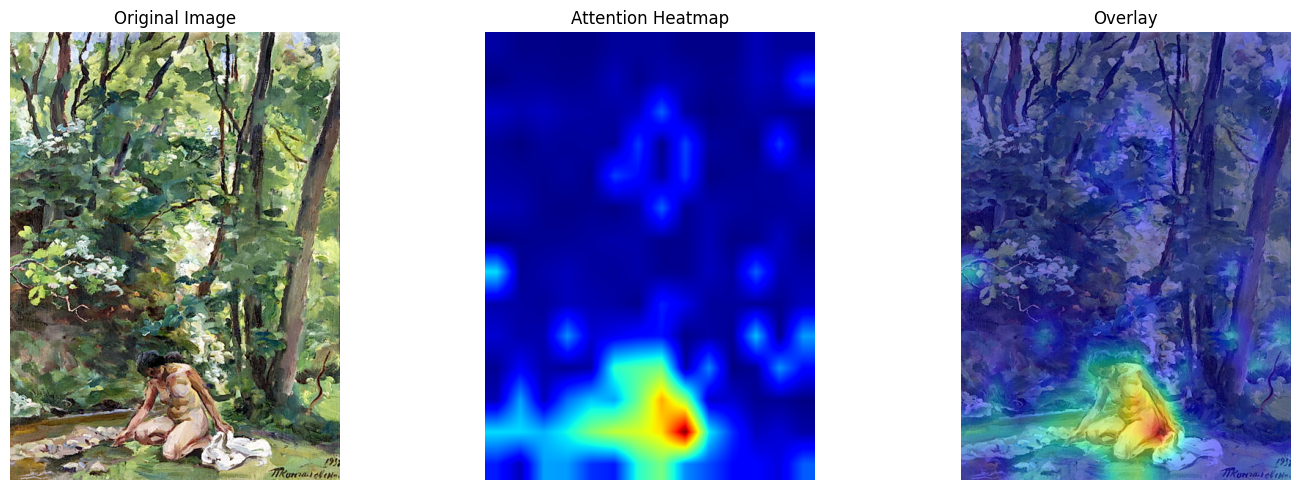

In [30]:
device = torch.device("mps")

# Load vocabulary
vocab = load_vocab(VOCAB_PATH)

# Patch ViT to force eager attention for visualization
original_loader = ViTModel.from_pretrained

def patched_loader(*args, **kwargs):
    kwargs["attn_implementation"] = "eager"
    return original_loader(*args, **kwargs)

with patch("transformers.ViTModel.from_pretrained", side_effect=patched_loader):
    model = FlashViTCaptionModel(
        vocab_size=len(vocab),
        embed_dim=512,
        num_heads=8,
        ff_dim=2048,
        num_decoder_layers=6,
        vit_model_path=VIT_MODEL_PATH
    ).to(device)

# Load model weights
state = torch.load(MODEL_PATH, map_location=device)
if isinstance(state, dict) and ("state_dict" in state or "model_state_dict" in state):
    model.load_state_dict(state.get("model_state_dict", state.get("state_dict")))
else:
    model.load_state_dict(state)

model.eval()

# Pick a random image
image_files = []
for root, _, files in os.walk(IMG_DIR):
    image_files.extend(
        os.path.join(root, f) for f in files
        if f.lower().endswith((".jpg", ".jpeg", ".png"))
    )

if image_files:
    img_path = random.choice(image_files)
    fig = visualize_attention_map(model, img_path, device=device)
    if fig:
        plt.show()
else:
    print("No images found.")

## Conclusion

In this assignment, we successfully implemented and evaluated two distinct image captioning architectures on the ArtEmis dataset.

1. **Architecture**:  
   The **Vision Transformer** demonstrated vastly superior performance compared to the CNN-LSTM baseline. It achieved significantly higher scores in all captioning metrics (e.g., **METEOR 0.206 vs 0.127**) and showed a dramatic improvement in **Emotion Accuracy (87% vs 52%)**. This highlights the effectiveness of the self-attention mechanism in capturing the complex interplay between visual features and affective language.

2. **Embeddings**:  
   Contrary to standard expectations, **TF-IDF** provided the best performance, outperforming both Word2Vec and GloVe. This indicates that simple, dataset-specific statistical embeddings can sometimes surpass general-purpose pre-trained embeddings in specialized domains.

3. **Emotion**:  
   The integration of an emotion classification head was highly successful in the Transformer model, allowing it to act as a dual-purpose system that can both describe and *feel* the artwork.
